<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Loading-the-input-data" data-toc-modified-id="Loading-the-input-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Loading the input data</a></span><ul class="toc-item"><li><span><a href="#Marking-outliers" data-toc-modified-id="Marking-outliers-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Marking outliers</a></span></li><li><span><a href="#Filtering" data-toc-modified-id="Filtering-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Filtering</a></span></li></ul></li><li><span><a href="#k-Nearest-Neighbors" data-toc-modified-id="k-Nearest-Neighbors-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>k-Nearest Neighbors</a></span></li></ul></div>

# Elo Merchant Category Recommendation - kNN
End date: _2019. february 19._<br/>

This tutorial notebook is the second part of a seriers for [Elo Mechant Category Recommendation](https://www.kaggle.com/c/elo-merchant-category-recommendation) contest organized by Elo, one of the largest payment brands in Brazil. It has built partnerships with merchants in order to offer promotions or discounts to cardholders. The objective of the competition is to identify and serve the most relevant opportunities to individuals, by uncovering signals in customer loyalty. The input files are available from the [download](https://www.kaggle.com/c/elo-merchant-category-recommendation/data) section of the contest:

- **train.csv**,  **test.csv**: list of `card_ids` that can be used for training and testing
- **historical_transactions.csv**: contains up to 3 months' worth of transactions for every card at any of the provided `merchant_ids`
- **new_merchant_transactions.csv**: contains the transactions at new merchants (`merchant_ids` that this particular `card_id` 
has not yet visited) over a period of two months
- **merchants.csv**: contains aggregate information for each `merchant_id` represented in the data set

In [1]:
import gc
import math
import time
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from functools import wraps
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)
sns.set(rc={'figure.figsize':(15, 6)})

Using TensorFlow backend.


In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Starting memory usage: {:5.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min >= np.iinfo(np.int64).min and c_max <= np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min >= np.finfo(np.float16).min and c_max <= np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min >= np.finfo(np.float32).min and c_max <= np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Reduced memory usage: {:5.2f} MB ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
class TimeMeasurer:
    def __init__(self):
        self.start_time = time.time()
        print ("Started at {}".format(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")))
    
    def stop(self):
        self.elapsed_time = time.time() - self.start_time
        print("Elapsed time max: {:.3f}s".format(self.elapsed_time))

## Loading the input data

In [4]:
df_merch = pd.read_csv("input/merchants.csv")
print("{:,} records and {} features in merchant set.".format(df_merch.shape[0], df_merch.shape[1]))

334,696 records and 22 features in merchant set.


In [5]:
df_merch['category_1'] = df_merch['category_1'].map({'N': 0, 'Y': 1})
df_merch['category_2'] = pd.to_numeric(df_merch['category_2'])
df_merch['category_4'] = df_merch['category_4'].map({'N': 0, 'Y': 1})
df_merch['most_recent_sales_range'] = df_merch['most_recent_sales_range'].map({'E': 0, 'D': 1, 'C': 2, 'B': 3, 'A': 4})
df_merch['most_recent_purchases_range'] = df_merch['most_recent_purchases_range'].map({'E': 0, 'D': 1, 'C': 2, 'B': 3, 'A': 4})

In [6]:
dropping = ['city_id', 'state_id']
for var in dropping:
    df_merch = df_merch.drop(var, axis=1)

In [7]:
df_merch = reduce_mem_usage(df_merch)

Starting memory usage: 51.07 MB
Reduced memory usage: 20.43 MB (60.0% reduction)


In [8]:
df_new_trans = pd.read_csv("input/trans_merch_new_agg.csv", index_col=0)
df_new_trans = reduce_mem_usage(df_new_trans)

df_hist_trans = pd.read_csv("input/trans_merch_hist_agg.csv", index_col=0)
df_hist_trans = reduce_mem_usage(df_hist_trans)

Starting memory usage: 354.01 MB
Reduced memory usage: 84.35 MB (76.2% reduction)
Starting memory usage: 397.39 MB
Reduced memory usage: 112.08 MB (71.8% reduction)


In [9]:
df_train = pd.read_csv("input/train.csv")
df_train = reduce_mem_usage(df_train)

df_test = pd.read_csv("input/test.csv")
df_test = reduce_mem_usage(df_test)

print("{:,} records and {} features in train set.".format(df_train.shape[0], df_train.shape[1]))
print("{:,} records and {} features in test set.".format(df_test.shape[0], df_test.shape[1]))

Starting memory usage:  9.24 MB
Reduced memory usage:  4.04 MB (56.2% reduction)
Starting memory usage:  4.72 MB
Reduced memory usage:  2.24 MB (52.5% reduction)
201,917 records and 6 features in train set.
123,623 records and 5 features in test set.


In [10]:
df_train = pd.merge(df_train, df_hist_trans, on='card_id',how='left')
df_test = pd.merge(df_test, df_hist_trans, on='card_id',how='left')

df_train = pd.merge(df_train, df_new_trans, on='card_id', how='left')
df_test = pd.merge(df_test, df_new_trans, on='card_id', how='left')

In [11]:
del df_hist_trans
del df_new_trans
gc.collect()

72

In [12]:
df_train[:3]

,first_active_month,card_id,feature_1,feature_2,feature_3,target,hist_transactions_count,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_active_months_lag3_sum,...,new_purchase_dayofweek_max,new_purchase_dayofweek_min,new_purchase_dayofweek_std,new_purchase_dayofweek_mode,new_purchase_quarter_mean,new_purchase_quarter_median,new_purchase_quarter_max,new_purchase_quarter_min,new_purchase_quarter_std,new_purchase_quarter_mode
0,2017-06,C_ID_92a2005557,5,2,1,-0.820312,1,252.0,0.951172,777.0,...,6.0,0.0,2.029297,4.0,1.478516,1.0,2.0,1.0,0.510742,1.0
1,2017-01,C_ID_3d0044924f,4,1,0,0.392822,1,354.0,0.969727,1095.0,...,4.0,0.0,1.643555,0.0,1.000000,1.0,1.0,1.0,0.000000,1.0
2,2016-08,C_ID_d639edf6cd,2,2,0,0.687988,1,42.0,0.954590,132.0,...,5.0,5.0,NaN,5.0,2.000000,2.0,2.0,2.0,NaN,2.0


In [13]:
df_test[:3]

,first_active_month,card_id,feature_1,feature_2,feature_3,hist_transactions_count,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_active_months_lag3_sum,hist_active_months_lag3_mean,...,new_purchase_dayofweek_max,new_purchase_dayofweek_min,new_purchase_dayofweek_std,new_purchase_dayofweek_mode,new_purchase_quarter_mean,new_purchase_quarter_median,new_purchase_quarter_max,new_purchase_quarter_min,new_purchase_quarter_std,new_purchase_quarter_mode
0,2017-04,C_ID_0ab67a22ab,3,3,1,1,47.0,0.662109,213.0,3.0,...,5.0,2.0,1.527344,2.0,1.000000,1.0,1.0,1.0,0.000000,1.0
1,2017-01,C_ID_130fd0cbdd,2,3,0,1,77.0,0.987305,234.0,3.0,...,6.0,0.0,2.359375,0.0,1.400391,1.0,2.0,1.0,0.516602,1.0
2,2017-08,C_ID_b709037bc5,5,1,1,1,9.0,0.692383,39.0,3.0,...,3.0,1.0,1.414062,1.0,1.000000,1.0,1.0,1.0,0.000000,1.0


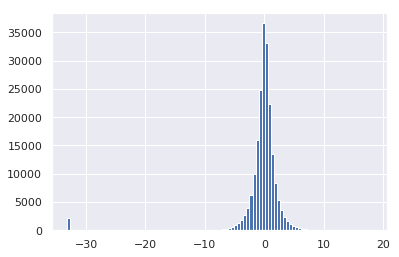

In [14]:
df_train['target'].hist(bins=100)

### Marking outliers

In [15]:
df_train['is_outlier'] = df_train['target'].apply(lambda x: 1 if x < -30 else 0)

In [16]:
len(df_train[df_train['is_outlier'] == 1]['is_outlier'])

2207

Text(0, 0.5, 'Frequency')

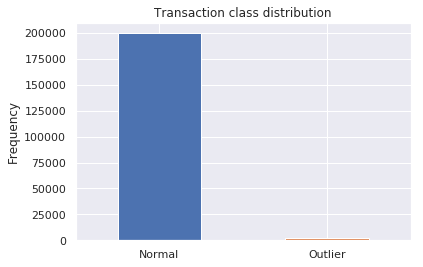

In [17]:
count_classes = pd.value_counts(df_train['is_outlier'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), ["Normal", "Outlier"])
plt.ylabel("Frequency")

### Filtering

In [18]:
df_train.drop(columns=['card_id', 'first_active_month', 'hist_merchant_id_mode', 'new_merchant_id_mode'], inplace=True, axis=1)
df_test.drop(columns=['card_id', 'first_active_month', 'hist_merchant_id_mode', 'new_merchant_id_mode'], inplace=True, axis=1)

In [19]:
len(df_train), len(df_test)

(201917, 123623)

In [20]:
df_train.dropna(how='any', axis=0, inplace=True)
df_test.dropna(how='any', axis=0, inplace=True)

In [21]:
len(df_train), len(df_test)

(147718, 90384)

In [22]:
for f in df_train.columns:
    if f != 'is_outlier':
        mean = df_train[f].mean()
        std = df_train[f].std()
        if math.isnan(mean):
            mean = df_train[f].astype(int).mean()
            std = df_train[f].astype(int).std()
    
        df_train[f] = (df_train[f] - mean)/std
        print('{}: {:.4f} ({:.4f})'.format(f, mean, std))

feature_1: 3.0877 (1.1951)
feature_2: 1.7326 (0.7500)
feature_3: 0.5543 (0.4970)
target: -0.4637 (3.0914)
hist_transactions_count: 1.0000 (0.0000)
hist_authorized_flag_sum: 96.7168 (111.3211)
hist_authorized_flag_mean: 0.1419 (0.3490)
hist_active_months_lag3_sum: 313.4754 (349.7907)
hist_active_months_lag3_mean: 2.9866 (0.1149)
hist_active_months_lag6_sum: 626.7824 (699.3774)
hist_active_months_lag6_mean: 5.9466 (0.2249)
hist_active_months_lag12_sum: 1229.6961 (1374.6195)
hist_active_months_lag12_mean: 11.1854 (0.4336)
hist_avg_sales_lag3_sum: 13026.3418 (150941.2031)
hist_avg_sales_lag3_mean: 130.5023 (1961.9861)
hist_avg_sales_lag6_sum: 12329.6572 (141868.8281)
hist_avg_sales_lag6_mean: 123.9150 (1847.1615)
hist_avg_sales_lag12_sum: 11424.0674 (138272.3594)
hist_avg_sales_lag12_mean: 114.8046 (1782.2146)
hist_avg_purchases_lag3_sum: inf (nan)
hist_avg_purchases_lag3_mean: inf (nan)
hist_avg_purchases_lag6_sum: inf (nan)
hist_avg_purchases_lag6_mean: inf (nan)
hist_avg_purchases_lag12

new_category_2_trans_nanperc: 4.6427 (12.1898)
new_category_2_merch_sum: 15.9339 (19.8446)
new_category_2_merch_mean: 2.1792 (1.4587)
new_category_2_merch_mode: 2.2388 (1.5272)
new_category_2_merch_nancnt: 0.9026 (1.3522)
new_category_2_merch_nanperc: 11.9043 (16.9196)
new_category_3_sum: 4.6446 (7.0415)
new_category_3_mean: 0.5316 (0.5310)
new_category_3_mode: 0.5587 (0.5738)
new_category_3_nancnt: 0.0000 (0.0000)
new_category_3_nanperc: 3.1530 (9.2390)
new_category_4_sum: 4.0277 (5.1978)
new_category_4_mean: 0.2198 (0.4141)
new_city_id_nunique: 2.5745 (1.7250)
new_city_id_mode: 129.5956 (99.5631)
new_city_id_nancnt: 0.0000 (0.0000)
new_city_id_nanperc: 0.0000 (0.0000)
new_installments_sum: 5.4636 (9.0421)
new_installments_median: 0.5913 (0.7818)
new_installments_mean: 0.5650 (0.8297)
new_installments_max: 1.5609 (3.5678)
new_installments_min: 0.2161 (0.7393)
new_installments_std: 0.3332 (0.9593)
new_installments_mode: 0.5047 (0.7122)
new_installments_nancnt: 0.0000 (0.0000)
new_insta

## k-Nearest Neighbors
http://dataaspirant.com/2016/12/30/k-nearest-neighbor-implementation-scikit-learn/

In [33]:
def SplitIntoTrainTestSet(df, cols, test_perc=0.2, verbose=True):
    X_train, X_test = train_test_split(df[cols], test_size=0.2, random_state=42)

    y_train = X_train['is_outlier']
    X_train = X_train.drop(['is_outlier'], axis=1)

    y_test = X_test['is_outlier']
    X_test = X_test.drop(['is_outlier'], axis=1)
    
    if verbose:
        print('There are {:,} records and {} fetures in the training set and {:,} records and {} fetures in the test set.'.format(
            X_train.shape[0],
            X_train.shape[1],
            X_test.shape[0],
            X_test.shape[1]
        ))

    return X_train.values, y_train, X_test.values, y_test

def createReconstructionError(model, X_test, y_test):
    predictions = model.predict(X_test)
    mse = np.mean(np.power(X_test - predictions, 2), axis=1)
    error_df = pd.DataFrame({
        'reconstruction_error': mse,
        'true_class': y_test
    })
    return error_df

def plotROCcurve(error_df):
    fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
    roc_auc = auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-0.001, 1])
    plt.ylim([0, 1.001])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

def plotRecallPrecisionCurve(error_df):
    precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
    plt.plot(recall, precision, 'b', label='Precision-Recall curve')
    plt.title('Recall vs Precision')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()
    return precision, recall, th

def plotThresholdPrecisionCurve(th, precision):
    plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
    plt.title('Precision for different threshold values')
    plt.xlabel('Threshold')
    plt.ylabel('Precision')
    plt.show()

def plotReconstructionErrorDataPoints(error_df, threshold):
    groups = error_df.groupby('true_class')
    fig, ax = plt.subplots()

    for name, group in groups:
        ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
                label= "Fraud" if name == 1 else "Normal")
    ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
    ax.legend()
    plt.title("Reconstruction error for different classes")
    plt.ylabel("Reconstruction error")
    plt.xlabel("Data point index")
    plt.show()

def drawConfusionMatrix(error_df, threshold):
    y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
    conf_matrix = confusion_matrix(error_df.true_class, y_pred)
    plt.figure(figsize=(12, 12))
    sns.heatmap(conf_matrix, xticklabels=["Normal", "Outlier"], yticklabels=["Normal", "Outlier"], annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()

In [24]:
cols = ['feature_1', 'feature_2', 'feature_3', 'hist_authorized_flag_sum', 'hist_active_months_lag3_sum', 'hist_active_months_lag6_sum', 'hist_active_months_lag12_sum', 'hist_avg_sales_lag3_sum', 'hist_avg_sales_lag3_mean', 'hist_avg_sales_lag6_sum', 'hist_avg_sales_lag6_mean', 'hist_avg_sales_lag12_sum', 'hist_avg_sales_lag12_mean', 'hist_category_1_trans_sum', 'hist_category_1_merch_sum', 'hist_category_2_trans_sum', 'hist_category_2_trans_mean', 'hist_category_2_trans_nancnt', 'hist_category_2_trans_nanperc', 'hist_category_2_merch_sum', 'hist_category_2_merch_mean', 'hist_category_2_merch_nancnt', 'hist_category_2_merch_nanperc', 'hist_category_3_sum', 'hist_category_3_nanperc', 'hist_category_4_sum', 'hist_city_id_nunique', 'hist_city_id_mode', 'hist_installments_sum', 'hist_installments_mean', 'hist_installments_max', 'hist_installments_min', 'hist_installments_std', 'hist_installments_mode', 'hist_merchant_id_nunique', 'hist_merchant_id_nancnt', 'hist_merchant_category_id_trans_nunique', 'hist_merchant_category_id_trans_mode', 'hist_merchant_group_id_nunique', 'hist_merchant_group_id_mode', 'hist_merchant_category_id_merch_nunique', 'hist_merchant_category_id_merch_mode', 'hist_month_lag_min', 'hist_month_lag_max', 'hist_month_lag_mean', 'hist_most_recent_sales_range_sum', 'hist_most_recent_sales_range_max', 'hist_most_recent_sales_range_mode', 'hist_most_recent_purchases_range_sum', 'hist_most_recent_purchases_range_max', 'hist_most_recent_purchases_range_mode', 'hist_numerical_1_mean', 'hist_numerical_1_std', 'hist_numerical_1_mode', 'hist_numerical_2_mean', 'hist_numerical_2_std', 'hist_state_id_nunique', 'hist_state_id_mode', 'hist_subsector_id_trans_nunique', 'hist_subsector_id_trans_mode', 'hist_subsector_id_merch_nunique', 'hist_subsector_id_merch_mode', 'hist_purchase_amount_sum', 'hist_purchase_amount_mean', 'hist_purchase_amount_max', 'hist_purchase_amount_std', 'hist_purchase_year_mean', 'hist_purchase_year_median', 'hist_purchase_year_max', 'hist_purchase_year_mode', 'hist_purchase_month_mean', 'hist_purchase_month_median', 'hist_purchase_month_max', 'hist_purchase_month_min', 'hist_purchase_month_std', 'hist_purchase_month_mode', 'hist_purchase_day_mean', 'hist_purchase_day_median', 'hist_purchase_day_max', 'hist_purchase_day_min', 'hist_purchase_day_std', 'hist_purchase_day_mode', 'hist_purchase_hour_mean', 'hist_purchase_hour_median', 'hist_purchase_hour_max', 'hist_purchase_hour_min', 'hist_purchase_hour_std', 'hist_purchase_hour_mode', 'hist_purchase_weekofyear_mean', 'hist_purchase_weekofyear_median', 'hist_purchase_weekofyear_max', 'hist_purchase_weekofyear_min', 'hist_purchase_weekofyear_std', 'hist_purchase_weekofyear_mode', 'hist_purchase_dayofweek_median', 'hist_purchase_dayofweek_max', 'hist_purchase_dayofweek_min', 'hist_purchase_dayofweek_mode', 'hist_purchase_quarter_median', 'hist_purchase_quarter_max', 'hist_purchase_quarter_min', 'hist_purchase_quarter_mode', 'new_authorized_flag_sum', 'new_active_months_lag3_sum', 'new_active_months_lag3_mean', 'new_active_months_lag6_sum', 'new_active_months_lag12_sum', 'new_avg_sales_lag3_sum', 'new_avg_sales_lag3_mean', 'new_avg_sales_lag6_sum', 'new_avg_sales_lag6_mean', 'new_avg_sales_lag12_sum', 'new_avg_sales_lag12_mean', 'new_avg_purchases_lag3_sum', 'new_avg_purchases_lag3_mean', 'new_avg_purchases_lag6_sum', 'new_avg_purchases_lag6_mean', 'new_avg_purchases_lag12_sum', 'new_avg_purchases_lag12_mean', 'new_category_1_trans_sum', 'new_category_1_merch_sum', 'new_category_2_trans_sum', 'new_category_2_trans_mean', 'new_category_2_trans_nanperc', 'new_category_2_merch_sum', 'new_category_2_merch_nancnt', 'new_category_2_merch_nanperc', 'new_category_3_sum', 'new_category_3_nanperc', 'new_category_4_sum', 'new_city_id_nunique', 'new_city_id_mode', 'new_installments_sum', 'new_installments_max', 'new_installments_min', 'new_installments_mode', 'new_merchant_id_nunique', 'new_merchant_id_nancnt', 'new_merchant_id_nanperc', 'new_merchant_category_id_trans_nunique', 'new_merchant_category_id_trans_mode', 'new_merchant_group_id_nunique', 'new_merchant_group_id_mode', 'new_merchant_group_id_nanperc', 'new_merchant_category_id_merch_nunique', 'new_merchant_category_id_merch_mode', 'new_merchant_category_id_merch_nanperc', 'new_month_lag_min', 'new_month_lag_max', 'new_most_recent_sales_range_sum', 'new_most_recent_sales_range_max', 'new_most_recent_sales_range_mode', 'new_most_recent_purchases_range_sum', 'new_most_recent_purchases_range_max', 'new_most_recent_purchases_range_min', 'new_most_recent_purchases_range_mode', 'new_numerical_1_mean', 'new_numerical_1_median', 'new_numerical_1_max', 'new_numerical_1_std', 'new_numerical_2_mean', 'new_numerical_2_median', 'new_numerical_2_max', 'new_numerical_2_std', 'new_state_id_nunique', 'new_state_id_mode', 'new_subsector_id_trans_nunique', 'new_subsector_id_trans_mode', 'new_subsector_id_merch_nunique', 'new_subsector_id_merch_mode', 'new_subsector_id_merch_nanperc', 'new_purchase_amount_sum', 'new_purchase_year_mean', 'new_purchase_year_median', 'new_purchase_year_max', 'new_purchase_year_min', 'new_purchase_year_mode', 'new_purchase_month_mean', 'new_purchase_month_median', 'new_purchase_month_max', 'new_purchase_month_min', 'new_purchase_month_mode', 'new_purchase_day_mean', 'new_purchase_day_median', 'new_purchase_day_max', 'new_purchase_day_min', 'new_purchase_day_std', 'new_purchase_day_mode', 'new_purchase_hour_mean', 'new_purchase_hour_median', 'new_purchase_hour_max', 'new_purchase_hour_min', 'new_purchase_hour_std', 'new_purchase_hour_mode', 'new_purchase_weekofyear_mean', 'new_purchase_weekofyear_median', 'new_purchase_weekofyear_max', 'new_purchase_weekofyear_min', 'new_purchase_weekofyear_std', 'new_purchase_weekofyear_mode', 'new_purchase_dayofweek_mean', 'new_purchase_dayofweek_median', 'new_purchase_dayofweek_max', 'new_purchase_dayofweek_min', 'new_purchase_dayofweek_mode', 'new_purchase_quarter_mean', 'new_purchase_quarter_median', 'new_purchase_quarter_max', 'new_purchase_quarter_min', 'new_purchase_quarter_mode', 'is_outlier']
X_train, y_train, X_test, y_test = SplitIntoTrainTestSet(df_train, cols)

There are 118,174 records and 210 fetures in the training set and 29,544 records and 210 fetures in the test set.


Check how many outliers in the first 10k, 20k, 50k, 75k, 100k and all elements.

In [29]:
item_array = [10000, 20000, 50000, 75000, 100000, len(y_train)]
for c in item_array:
    indices = [i for i, x in enumerate(y_train[:c]) if x == 1]

    print('There are {} ({:.4f}%) outliers in the first {:,} in the training set.'.format(
        len(indices),
        len(indices)/c,
        c
    ))

There are 74 (0.0074%) outliers in the first 10,000 in the training set.
There are 150 (0.0075%) outliers in the first 20,000 in the training set.
There are 383 (0.0077%) outliers in the first 50,000 in the training set.
There are 574 (0.0077%) outliers in the first 75,000 in the training set.
There are 761 (0.0076%) outliers in the first 100,000 in the training set.
There are 885 (0.0075%) outliers in the first 118,174 in the training set.


In [30]:
t = TimeMeasurer()
neigh = KNeighborsClassifier(n_neighbors = 5, weights='distance', algorithm='auto')
neigh.fit(X_train, y_train)

y_pred = neigh.predict(X_test)
print("Accuracy is {:.3f}%".format(accuracy_score(y_test, y_pred)*100))
t.stop()

Started at 2019-01-09 12:07:13
Accuracy is 99.174%
Elapsed time max: 1699.138s


In [32]:
print('Are there any outliers in the prediction: {}'.format(1 in y_pred))
print('Number of outliers in prediction: {}'.format(len(y_pred[y_pred == 1])))

Are there any outliers in the prediction: True
Number of outliers in prediction: 4


In [1]:
neigh.save('models/knn_distance_n5.h5')

NameError: name 'neigh' is not defined

In [ ]:
t = TimeMeasurer()
error_df = createReconstructionError(neigh, X_test, y_test)
t.stop()

In [ ]:
error_df.describe()

In [ ]:
plotReconstructionErrors(error_df)

In [ ]:
plotROCcurve(error_df)

In [ ]:
precision, recall, th = plotRecallPrecisionCurve(error_df)

In [ ]:
plotThresholdPrecisionCurve(th, precision)

In [ ]:
threshold = 2
plotReconstructionErrorDataPoints(error_df, threshold)

In [ ]:
drawConfusionMatrix(error_df, threshold)

In [ ]:
for K in range(5, 10):
    K_value = K+1
    neigh = KNeighborsClassifier(n_neighbors = K_value, weights='distance', algorithm='auto')
    neigh.fit(X_train[:10000], y_train[:10000])

    y_pred = neigh.predict(X_test[:10000])
    print("Accuracy for {} is {:.3f}".format(K_value, accuracy_score(y_test[:10000], y_pred)*100))